***Regularización: Redes elásticas***

El objetivo de este Notebook es la presentación de las técnicas de Redes elásticas (incluido Ridge y Lasso) como alternativa específica de regresión que está basada en el proceso de regularización.

**Business understanding**

El problema de determinar precios adecuados (conocido en inglés como pricing) es fundamental dentro de la estrategia de una empresa o firma. No en vano el precio es una de las características de un producto que usualmente ayuda a definir la estrategia.
Dado que los precios usualmente tienen conexión con el valor que los clientes asignan a los productos, se trata de un fenómeno de sicología del consumidor. Por eso los precios incluyen la forma en que los consumidores perciben el valor del producto y sus características, las cuales no son todas necesariamente tangibles.

El caso de estudio se relaciona con un proceso de estimación del precio de vehículos a partir de las características de este, a través del cual trabajaremos el concepto de regularización en un modelo predictivo.

**Data understanding & preparation**

[Para poder descargar los datos](https://sites.google.com/site/cursosalvarado/datafiles)

In [ ]:
install.packages("glmnet")
install.packages("caret")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’, ‘RcppEigen’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’




In [ ]:
library(glmnet)
library(caret)

Loading required package: Matrix

Loaded glmnet 4.1-8

Loading required package: ggplot2

Loading required package: lattice



In [ ]:
carros<-read.csv("carros2011imputado.csv", header=TRUE, sep=";", dec=",")
str(carros)

'data.frame':	93 obs. of  27 variables:
 $ ID                        : int  1 2 3 4 5 6 7 8 9 10 ...
 $ tipo                      : chr  "Small" "Midsize" "Compact" "Midsize" ...
 $ millas_por_galon_ciudad   : int  25 18 20 19 22 22 19 16 19 16 ...
 $ millas_por_galon_carretera: int  31 25 26 26 30 31 28 25 27 25 ...
 $ numero_de_airbags         : chr  "No tiene" "Conductor y copiloto" "Conductor" "Conductor y copiloto" ...
 $ traccion                  : chr  "Delantera" "Delantera" "Delantera" "Delantera" ...
 $ cilindros                 : int  4 6 6 6 4 4 6 6 6 8 ...
 $ litros_motor              : num  1.8 3.2 2.8 2.8 3.5 2.2 3.8 5.7 3.8 4.9 ...
 $ caballos_fuerza           : int  140 200 172 172 208 110 170 180 170 200 ...
 $ revoluciones_por_minuto   : int  6300 5500 5500 5500 5700 5200 4800 4000 4800 4100 ...
 $ rev_motor_por_milla       : int  2890 2335 2280 2535 2545 2565 1570 1320 1690 1510 ...
 $ transmision_manual        : chr  "Si" "Si" "Si" "Si" ...
 $ capacidad_tanque     

De la estructura de los datos se obtienen las siguientes observaciones que llevarán a transformaciones de preparación de los datos (feature engineering):

1- Si la variable dependiente es el precio, hay 3 precios disponibles. Usar uno de ellos como predictor del otro probablemente no tiene sentido de negocio, porque no es el tipo de característica que va a estar disponible para predecir el precio de un nuevo vehículo. Por eso, dos de ellos serán descartados (dejaremos el precio promedio)

2- Las variables predictoras numéricas están todas asociadas a características físicas del carro. El ID del caso debe ser retirado como variable predictora.

3- Existen un conjunto de datos categóricos (tipo factor en R) que debemos transformar si deseamos que se incluyan como variables predictoras. Los airbags, el tipo de tracción y de transmisión son características no numéricas del vehículo. El tipo de vehículo. y el lugar de fabricación son posibles condicionantes del precio del vehículo también. La marca (fabricante) puede resultar interesante, más aún si tenemos en cuenta que la marca es un intangible muy importante en un vehículo, y hasta ahora ninguna de las variables podía capturar directamente intangibles de los vehículos. El modelo, en cambio, es casi único por cada vehículo (hay 93 modelos) luego es casi una variable identificadora y será descartada. Todas las demás variables categóricas cada una con k categorías a incluir se convertirán en k-1 variables binarias,

Dado que existen más de 20 posibles variables predictoras para un conjunto de tan solo 97 casos, el riesgo de overfitting puede ser grande, más aún si tenemos en cuenta que vamos a crear variables binarias para múltiples variables categóricas y requerimos bases de datos de entrenamiento y validación, incrementando aún más el riesgo mencionado. Todo ello va a implicar decisiones en el modelo y su validación.

Preparemos la base de datos:

In [ ]:
#guardar los modelos de los carros para interpretación
carmodelos<-carros$modelo
#remover el ID, el modelo y dos de los precios
carros<-within(carros,rm(ID,modelo,precio_basico,precio_equipado))
#crear variables dummy (binarias)
set.seed(1)
carroswin<-dummyVars("~.",data=carros)
carrosfin<-as.data.frame(predict(carroswin,newdata=carros))

,tipoCompact,tipoLarge,tipoMidsize,tipoSmall,tipoSporty,tipoVan,millas_por_galon_ciudad,millas_por_galon_carretera,numero_de_airbagsConductor,numero_de_airbagsConductor y copiloto,⋯,fabricanteOldsmobile,fabricantePlymouth,fabricantePontiac,fabricanteSaab,fabricanteSaturn,fabricanteSubaru,fabricanteSuzuki,fabricanteToyota,fabricanteVolkswagen,fabricanteVolvo
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,1,0,0,25,31,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,18,25,0,1,⋯,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,20,26,1,0,⋯,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,19,26,0,1,⋯,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,0,0,22,30,1,0,⋯,0,0,0,0,0,0,0,0,0,0
6,0,0,1,0,0,0,22,31,1,0,⋯,0,0,0,0,0,0,0,0,0,0
7,0,1,0,0,0,0,19,28,1,0,⋯,0,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,0,16,25,1,0,⋯,0,0,0,0,0,0,0,0,0,0
9,0,0,1,0,0,0,19,27,1,0,⋯,0,0,0,0,0,0,0,0,0,0


In [ ]:
summary(carrosfin)

  tipoCompact      tipoLarge       tipoMidsize       tipoSmall     
 Min.   :0.000   Min.   :0.0000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.000   1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:0.0000  
 Median :0.000   Median :0.0000   Median :0.0000   Median :0.0000  
 Mean   :0.172   Mean   :0.1183   Mean   :0.2366   Mean   :0.2258  
 3rd Qu.:0.000   3rd Qu.:0.0000   3rd Qu.:0.0000   3rd Qu.:0.0000  
 Max.   :1.000   Max.   :1.0000   Max.   :1.0000   Max.   :1.0000  
   tipoSporty        tipoVan        millas_por_galon_ciudad
 Min.   :0.0000   Min.   :0.00000   Min.   :15.00          
 1st Qu.:0.0000   1st Qu.:0.00000   1st Qu.:18.00          
 Median :0.0000   Median :0.00000   Median :21.00          
 Mean   :0.1505   Mean   :0.09677   Mean   :22.37          
 3rd Qu.:0.0000   3rd Qu.:0.00000   3rd Qu.:25.00          
 Max.   :1.0000   Max.   :1.00000   Max.   :46.00          
 millas_por_galon_carretera numero_de_airbagsConductor
 Min.   :20.00              Min.   :0.0000       

In [ ]:
carrosfin2<-within(carrosfin,rm(fabricanteLexus,tipoSporty,tracciónTrasera,transmisión_manualSi,
                                `numero_de_airbagsNo tiene`,
                                `hecho_o_no_en_USAHecho fuera de USA`))
#veamos la dimension final de la base de datos
dim(carrosfin2)

Warning message in rm(fabricanteLexus, tipoSporty, tracciónTrasera, transmisión_manualSi, :
“object 'tracciónTrasera' not found”
Warning message in rm(fabricanteLexus, tipoSporty, tracciónTrasera, transmisión_manualSi, :
“object 'transmisión_manualSi' not found”


[1] 93 60

Tenemos finalmente una base de datos con 58 variables predictoras y 93 datos (menos de dos casos por variable)

In [ ]:
#retiro la variable a predecir
predictores<-cbind(as.matrix(carrosfin2[,1:27]),as.matrix(carrosfin2[,29:59]))

**Modeling**

La multicolinealidad y la baja relación datos a variables hacen de este problema un caso complicado para las regresiones basadas en mínimos cuadrados. Obtengamos un modelo básico y observémoslo.

*Haciendo un modelo clásico*

In [ ]:
##entrenamiento y validación 80-20
set.seed(49584)
sample <- sample.int(nrow(carrosfin2), floor(.8*nrow(carrosfin2)))
carros.train <- carrosfin2[sample, ]
carros.test <- carrosfin2[-sample, ]

#haciendo el modelo
modeloaug<-lm(precio_promedio~.,data=carros.train)
modelocarstep<-step(modeloaug,direction="both",trace=0)
summary(modelocarstep)


Call:
lm(formula = precio_promedio ~ tipoCompact + tipoSmall + millas_por_galon_ciudad + 
    millas_por_galon_carretera + numero_de_airbagsConductor + 
    `traccionDoble tracci\xf3n` + cilindros + caballos_fuerza + 
    capacidad_tanque + capacidad_pasajeros + longitud + ancho + 
    espacio_para_dar_la_u + espacio_asiento_trasero + capacidad_baul + 
    peso_en_libras + `hecho_o_no_en_USAHecho en USA` + fabricanteAcura + 
    fabricanteAudi + fabricanteBMW + fabricanteBuick + fabricanteChevrolet + 
    fabricanteChrysler + fabricanteDodge + fabricanteFord + fabricanteHyundai + 
    fabricanteLincoln + `fabricanteMercedes-Benz` + fabricanteMercury + 
    fabricanteNissan + fabricanteOldsmobile + fabricantePlymouth + 
    fabricantePontiac + fabricanteSaab + fabricanteVolkswagen + 
    fabricanteVolvo, data = carros.train)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.8630 -0.9726  0.0000  0.8940  2.8987 

Coefficients:
                                  Estimate Std. Error 

El modelo incluyó 25 variables predictoras. Observe que varias de ellas (11 en total) son no significativas. Una mirada, por ejemplo, a los coeficientes de millas por galón en ciudad y en carretera muestran que tienen signos contrarios, lo que no tiene sentido de negocio y es un clásico signo de multicolinealidad.

La cantidad de variables y la multicolinealidad generan un modelo que, a simple vista, se ve extraño.

**Regularización**

Parte de la problemática es la restricción de que los estimadores deben ser insesgados, y por tanto la suma de los residuales debe ser cero. Eso puede crear una alta varianza en los estimadores, al punto de ver los resultados que observamos.

Puesto que el error en una predicción es la suma de el sesgo y la varianza de la estimación (más el error residual), permitir cierto sesgo que disminuya en mayor proporción la varianza es un mecanismo que claramente puede permitir mejores predicciones.

Para usar la librería glmnet es necesario crear matrices separadas para los predictores y la variable pendiente. En este notebook ya creamos los predictores: falta la variable dependiente

In [ ]:
predic.train<-cbind(as.matrix(carros.train[,1:27]),as.matrix(carros.train[,29:59]))
precio.train<-as.matrix(carros.train[,28])

predic.test<-cbind(as.matrix(carros.test[,1:27]),as.matrix(carros.test[,29:59]))
precio.test<-as.matrix(carros.test[,28])

Ahora vamos a crear modelos de redes elásticas para observar cómo se comportan para diversos valores del parámetro de penalización lambda.

Es importante anotar que, por defecto, las variables son estandarizadas por el procedimiento.

Con alpha=1 creamos un modelo lasso (penalizado en los valores absolutos de los coeficientes o L1) y con alpha=0 un ridge (penalizado en cuadrados de los coeficientes, o L2). Con 0.5 creamos una red elástica.

El hiperparámetro lambda genera cambios importantes en los modelos, y la escogencia de su valor no siempre es fácil. Veamos, por ejemplo, cómo cambian los coeficientes de una regresión regularizada dependiendo de lambda:

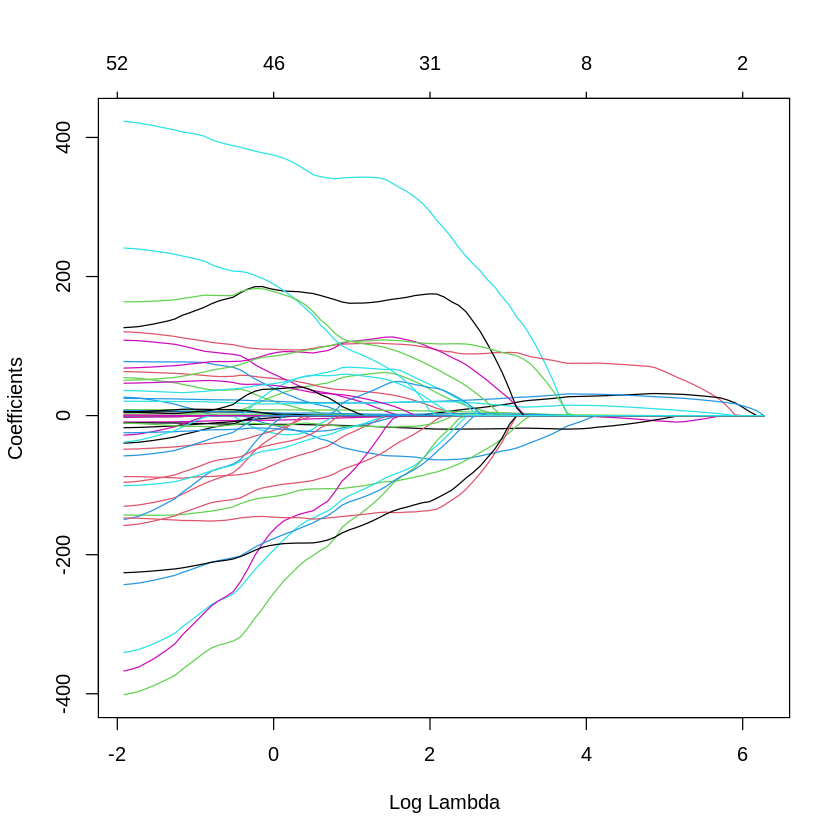

In [ ]:
fitlasso<-glmnet(predic.train,precio.train,alpha = 1)
fitridge<-glmnet(predic.train,precio.train,alpha = 0)

#ver la variacion de los coeficientes con el lambda
plot(fitlasso, xvar="lambda")

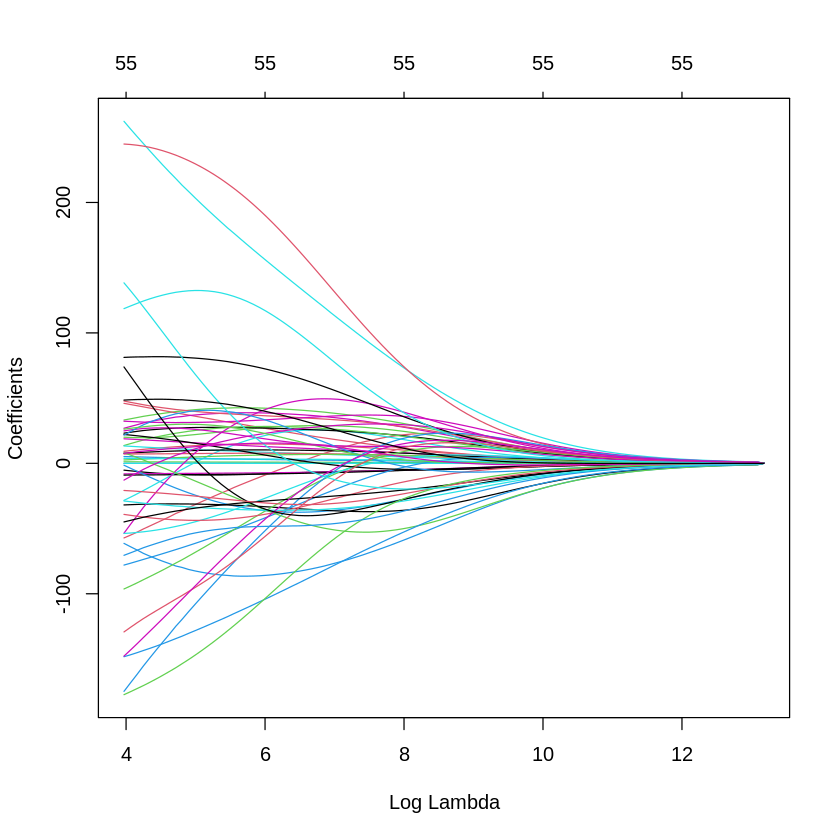

In [ ]:
plot(fitridge, xvar="lambda")

Se puede observar como los valores de lambda disminuyen los parámetros desde los de una regresión de mínimos cuadrados (a la izquierda) hasta una penalización alta de coeficientes y, por tanto, un alto sesgo (a la derecha). También puede verse que en el caso de lasso los parámetros se van volviendo cero de manera independiente, mientras en ridge la reducción tiende a ser general (en todos los parámetros)

**Validación cruzada**

¿Cómo escoger lambda? Una buena manera es probar el error que lambda comete en diferentes bases de “prueba”. La idea detrás de la validación cruzada es generar múltiples bases de entrenamiento y validación, creando múltiples modelos en la base de entrenamiento y evaluándolos múltiples veces en la base de validación.

Vamos a hacerlo para el caso de Ridge inicialmente:

In [ ]:
foundridge<-cv.glmnet(predic.train, precio.train,alpha=0,nfolds=5)

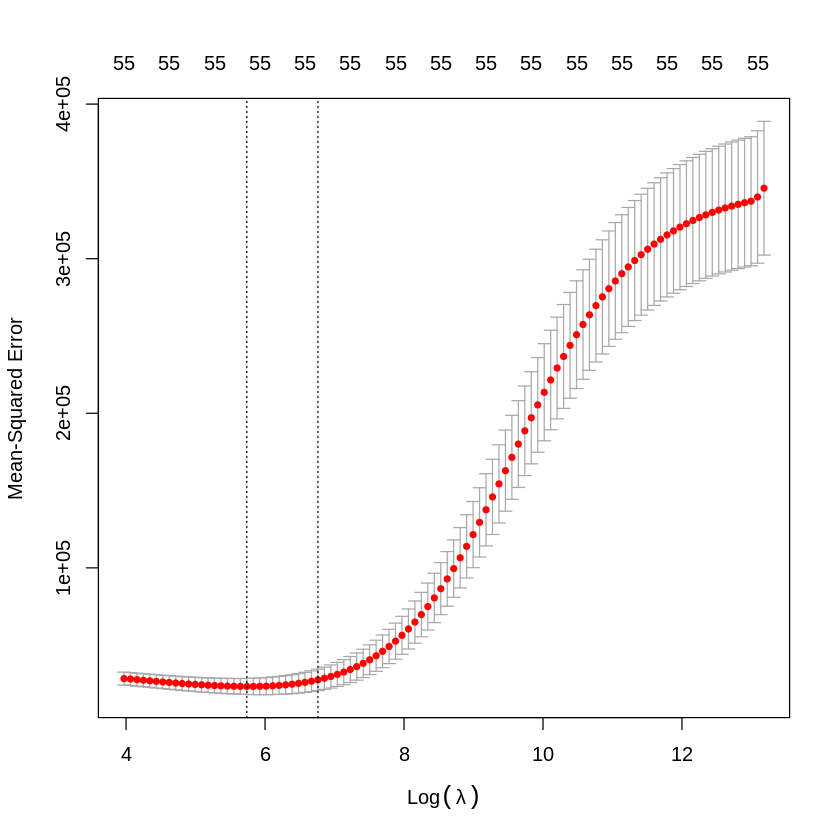

In [ ]:
#grafico lambda vs mse
plot(foundridge)

In [ ]:
#veo los lambda minimos
foundridge$lambda.1se

[1] 863.6858

In [ ]:
foundridge$lambda.min

[1] 310.3926

Este gráfico muestra los errores promedio de cada lambda, junto con sus errores estándar. El valor que minimiza esos errores en promedio es 1.77 (0.65 en el gráfico, donde se ve el logaritmo), pero se suele sugerir (Hastie lo hace) que se utilice un valor más alto, a no más de una desviación estándar del valor del error más bajo, para obtener un modelo más parsimonioso con un error similar, y evadir el overfitting.

**Analizando resultados**

Miremos los resultados usando ese valor de lambda con una desviación estándar más: 34.83

In [ ]:
coef(foundridge,s=foundridge$lambda.1se)

59 x 1 sparse Matrix of class "dgCMatrix"
                                                 s1
(Intercept)                           -0.8041865041
tipoCompact                           -0.1214155520
tipoLarge                              0.2073492443
tipoMidsize                            1.5016916139
tipoSmall                             -1.0045512856
tipoVan                               -0.5203058287
millas_por_galon_ciudad               -0.0712862043
millas_por_galon_carretera            -0.0721170205
numero_de_airbagsConductor             0.3245776693
numero_de_airbagsConductor y copiloto  1.3804097076
tracciónDelantera                     -0.4679435245
tracciónDoble tracción                -0.3751350309
cilindros                              0.4088717018
litros_motor                           0.3215515833
caballos_fuerza                        0.0182523861
revoluciones_por_minuto                0.0005000917
rev_motor_por_milla                   -0.0002494563
transmisión_manualNo  

Aquí los coeficientes se interpretan en el sentido de sus mayores o menores valores relativos y su signo.
Por ejemplo, entre los tamaños, Midsize y small son los más importantes, el primero aumentando el precio, y el último disminuyéndolo. Entre los fabricantes, las marcas de lujo aumentan el precio (Mercedes benz, Saab, Cadillac, Audi, Infinity) mientras que marcas más populares como Hyundai o Mercury lo disminuyen. Coeficientes más cercanos a cero marcan una baja importancia de la variable.

Mucho más interpretable suele ser un Lasso, porque puede llevar a cero muchos coeficientes:

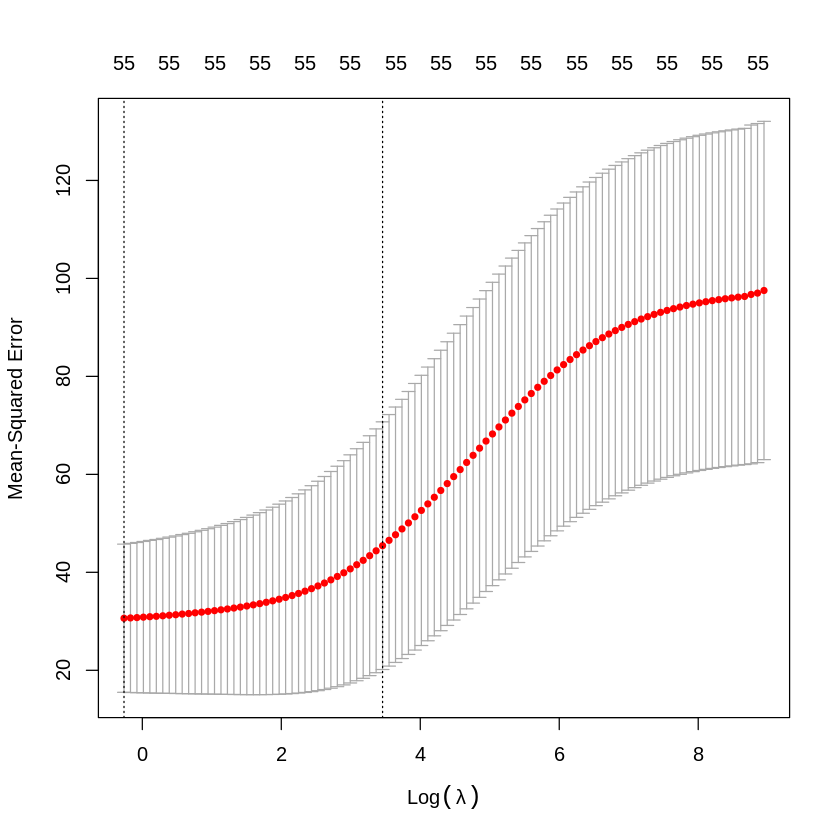

In [ ]:
foundlasso<-cv.glmnet(predic.train, precio.train,alpha=0,nfolds=5)

#grafico lambda vs mse
plot(foundlasso)

In [ ]:
#veo los lambda minimos
foundlasso$lambda.1se

[1] 31.74464

In [ ]:
foundlasso$lambda.min

[1] 0.7682611

In [ ]:
coef(fitlasso,s=foundlasso$lambda.min)

59 x 1 sparse Matrix of class "dgCMatrix"
                                                 s1
(Intercept)                            0.5384887372
tipoCompact                            .           
tipoLarge                              .           
tipoMidsize                            2.6038123280
tipoSmall                             -1.1392665912
tipoVan                                .           
millas_por_galon_ciudad                .           
millas_por_galon_carretera             .           
numero_de_airbagsConductor             .           
numero_de_airbagsConductor y copiloto  .           
tracciónDelantera                      .           
tracciónDoble tracción                 .           
cilindros                              .           
litros_motor                           .           
caballos_fuerza                        0.1167494635
revoluciones_por_minuto                .           
rev_motor_por_milla                    .           
transmisión_manualNo  

El modelo sesgado es más simple: un aumento de precio por la relación con los caballos de fuerza y efectos por algunas marcas específicas de lujo o económicas (no todas); pequeños efectos del espacio asiento trasero, el peso, y efectos del tipo de vehiculo. Si se usa el coeficiente de una desviación estándar por encima del mínimo se tiene un modelo sin predictores.

Ahora vamos a modelar una red elástica. Vamos a probar valores de alfa dese 0.1 hasta 0.9 para observar cuál puede ser el mejor:

In [ ]:
# aqui hago redes elasticas de 0.1 a 0.9
for (i in 1:10){
  assign(paste("found", i, sep=""), cv.glmnet(predic.train, precio.train, nfolds=5,
                                              alpha=i/10,))}

In [ ]:
min(foundridge$cvm)


[1] 29.96548

In [ ]:
min(found1$cvm)


[1] 31.25341

In [ ]:
min(found2$cvm)


[1] 29.37365

In [ ]:
min(found3$cvm)


[1] 35.30614

In [ ]:
min(found4$cvm)


[1] 30.92217

In [ ]:
min(found5$cvm)


[1] 31.75177

In [ ]:
min(found6$cvm)


[1] 30.11534

In [ ]:
min(found7$cvm)


[1] 35.10335

In [ ]:
min(found8$cvm)


[1] 28.8904

In [ ]:
min(found9$cvm)


[1] 30.6015

In [ ]:
min(foundlasso$cvm)

[1] 30.62782

Al parecer un modelo ridge y una red elástica con alpha=0.8 pueden ser buenos candidatos. Usaremos Lasso para comparar, dada su simplicidad. Creemos el modelo que nos falta:

In [ ]:
elastic8<-glmnet(predic.train,precio.train,alpha = 0.8)
coef(elastic8,s=found8$lambda.1se)


59 x 1 sparse Matrix of class "dgCMatrix"
                                               s1
(Intercept)                            5.71668685
tipoCompact                            .         
tipoLarge                              .         
tipoMidsize                            0.64956250
tipoSmall                              .         
tipoVan                                .         
millas_por_galon_ciudad                .         
millas_por_galon_carretera             .         
numero_de_airbagsConductor             .         
numero_de_airbagsConductor y copiloto  .         
tracciónDelantera                      .         
tracciónDoble tracción                 .         
cilindros                              .         
litros_motor                           .         
caballos_fuerza                        0.09346319
revoluciones_por_minuto                .         
rev_motor_por_milla                    .         
transmisión_manualNo                   .         
capacida

**Evaluación**

Finalmente vamos a evaluar los modelos en la base de datos de prueba basados en el RMSE y los criterios de negocio. Utilizaremos el lambda mínimo para los modelos de red elástica.

In [ ]:
#red elastica
predicciones1<-predict.glmnet(elastic5, predic.test, s=elastic5$lambda.min)

#ridge
predicciones2<-predict.glmnet(fitridge, predic.test, s=foundridge$lambda.min)

#lasso
predicciones3<-predict.glmnet(fitlasso, predic.test, s=foundlasso$lambda.min)

#stepwise
predicciones4<-predict(modelocarstep,carros.test)

In [ ]:
#calcular el MSE
erroreselastic=sqrt(mean((predicciones1-precio.test[,1])^2))
erroresridge=sqrt(mean((predicciones2-precio.test[,1])^2))
erroreslasso=sqrt(mean((predicciones3-precio.test[,1])^2))
erroresstep=sqrt(mean((predicciones4-precio.test[,1])^2))


In [ ]:
erroreselastic


[1] 6.267468

In [ ]:
erroresridge


[1] 5.503949

In [ ]:
erroreslasso


[1] 5.648705

In [ ]:
erroresstep

[1] 6.391214

El modelo ridge resulta el mejor predictor en la base de datos de validación. Si bien no se logra una mayor parsimonia (ni el modelo step ni los modelos que llevaron coeficientes a 0 obtuvieron mejores resultados), si parece lograrse una mejor predicción. Dado que los datos están en miles de dólares, la diferencia promedio en precisión entre los dos mejores modelos esta en el orden de los US$148 por predicción (algo cercano al 6%), lo cual, dependiendo de la aplicación, puede o no resultar valioso. El modelo lasso es quizás demasiado simple y comete errores mayores, así como la red elástica, con errores entre los cientos y los miles de dólares en promedio, lo que los descarta como candidatos viables.

En el modelo step es difícil saber o entender el efecto específico de cada variable independiente, en parte por la falta de estandarización y en parte por los problemas mencionados de multicolinealidad y parte por la baja relación casos/variables. En el modelo ridge, como se explicó, el tamaño relativo y signo de los coeficientes da idea de la importancia relativa de las variables.

**Conclusión**

Los modelos regularizados pueden ser una alternativa a los modelos insesgados para mejorar la predictibilidad, particularmente en entornos de baja razón casos/variables o con multicolinealidad. La interpretación de los resultados tiene cambios importantes que deben tenerse en cuenta. La idea de la regularización puede aplicarse a múltiples tipos de modelos que estén buscando minimizar una función de error, lo que la hace altamente aplicable en machine learning.